In [2]:
import batanalysis as ba
import swiftbat
import swifttools
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from scipy import fftpack
from pathlib import Path
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.modeling import models
from astropy.modeling.fitting import fitter_to_model_params
from numpy import mean
from numpy import arange
from scipy.fftpack import fft, rfft
import scipy.fft
from scipy.signal import find_peaks, welch
from scipy.optimize import curve_fit
import datetime
import os
import stingray
from stingray import Lightcurve, DynamicalPowerspectrum, AveragedPowerspectrum
from stingray.modeling import PSDLogLikelihood, PSDPosterior, PSDParEst
from lmfit import Parameters, Minimizer
from lmfit.models import LorentzianModel, ConstantModel
sourcename = "Swift J1727.8-1613"
source = swiftbat.source(sourcename)    # Can look up positions from Simbad, and can calculate exposure for a given pointing
topdir = Path("~/ICR_Project").expanduser()
datafilelistfile = topdir.joinpath("datafiles.txt")


In [3]:
if not datafilelistfile.exists():
    timerange = [swiftbat.string2datetime(t) for t in ("MJD60180", "MJD60204")]
    min_exposure_area = 1000     # cm^2 after cos adjust
    #table_stoo = swifttools.swift_too.ObsQuery(begin=timerange[0],end=timerange[1])
    sourceloc = swiftbat.simbadlocation(sourcename)
    source_batsource = swiftbat.source(ra=sourceloc[0], dec=sourceloc[1], name=sourcename)
    queryargs = dict(time=f"{timerange[0]:%Y-%m-%d} .. {timerange[1]:%Y-%m-%d}", fields='All', resultmax=0)
    table_stoo = ba.from_heasarc(**queryargs)
    
    exposures = np.array([source_batsource.exposure(ra=row['RA'], dec=row['DEC'], roll=row['ROLL_ANGLE'])[0] for row in table_stoo])
    table_exposed = table_stoo[exposures > min_exposure_area]
    download_multi = ba.download_swiftdata(table_exposed, match=['*brtms*'], quiet=True)
    f = datafilelistfile.open("wt")
    for obsid, entry in download_multi.items():
        if not entry['success']:
            continue
        datafile = entry['data'][0].localpath
        print(datafile, file = f)
    f.close()

In [4]:
lcsegments = []
# rate is rate over first 2 energy bins 15-50 keV
slice_ebins=slice(0,2)
timebin = 0.064
skiplength = int(60/timebin)
# Norm is mean-subtracted, stddev-scaled within a pointing
segdtype = np.dtype([('time', np.float64),('rate', np.int16),('norm', np.float32)])

for datafile in datafilelistfile.open().readlines():
    datafile = datafile.strip()
    obsdata = fits.getdata(datafile)
    # Split the data into arrays with no more than a second's gap
    splitlocs = np.argwhere(np.diff(obsdata['time']) > 1.5*timebin).ravel() + 1
    for segmentdata in np.split(obsdata, splitlocs):
        segmentdata = segmentdata[skiplength:]
        if len(segmentdata) == 0:
            continue
        segment = np.empty(len(segmentdata), dtype=segdtype)
        segment['time'] = segmentdata['time']
        rate = np.sum(segmentdata['COUNTS'][:,slice_ebins], axis=1)
        segment['rate'] = rate
        norm = (rate - np.mean(rate))/(0.001 + np.std(rate))
        segment['norm'] = np.clip(norm, -5, 5)
        lcsegments.append(segment)
        # Sort by segment start time
lcsegments = sorted(lcsegments, key = lambda x:x['time'][0])

In [5]:
datafile
len(lcsegments)
len(norm)
len(sigma_clip(norm, sigma=5, maxiters=None, cenfunc=np.mean, masked=False, copy=True))

17913

In [8]:
# Make sure the timebin is right
assert (0.9 * timebin) < np.median(np.diff(lcsegments[0]['time'])) < (1.5 * timebin)

# Use the segments to populate an array
t0 = lcsegments[0]['time'][0]
tmax = lcsegments[-1]['time'][-1]
ntimes = sp.fft.next_fast_len(int((tmax - t0)/timebin  + 10))    # 10 bins of slop, then round up to an FFT-friendly length
lcfull = np.zeros(ntimes)

for segment in lcsegments:
    n = len(segment)
    i0 = int((segment['time'][0] - t0)/timebin)
    lcfull[i0:i0+n] = segment['norm']
    
for datasegment in np.split(obsdata, splitlocs):
    # time of spacecraft, not always accurate because of clock error
    starttime = swiftbat.met2datetime(datasegment['time'][0])
    duration = datasegment['time'].ptp()
    print(f"{starttime:%Y-%m-%dT%H:%M:%S} + {duration:5.10f} seconds to the end of the block")
    if duration > 1300:
        longdatasegment = datasegment 
print(len(datasegment))

2023-08-25T20:06:04 + 1206.3360003233 seconds to the end of the block
18850


In [9]:
# Ignore periods below 10 minutes when looking for peak
def nice_plot(freqs, fpower, ax, **kwargs):   
    grasslevel = np.median(fpower) * 3
    fpower = fpower.copy()
    fpower[(fpower < grasslevel) | (freqs < 1/10)]
    ax.plot(freqs, fpower, **kwargs)
    #ax.set(yscale='log', ylim=[grasslevel, powermax*1.3], xlim=[0,1], ylabel="Power (logscale arbitrary units)")
    ax.set(yscale ='log',  xlim=[0.05,2], ylabel="Power(logscale arbitrary units)", xlabel="Frequency(hZ)")
    ax.set_ylim(bottom=grasslevel)

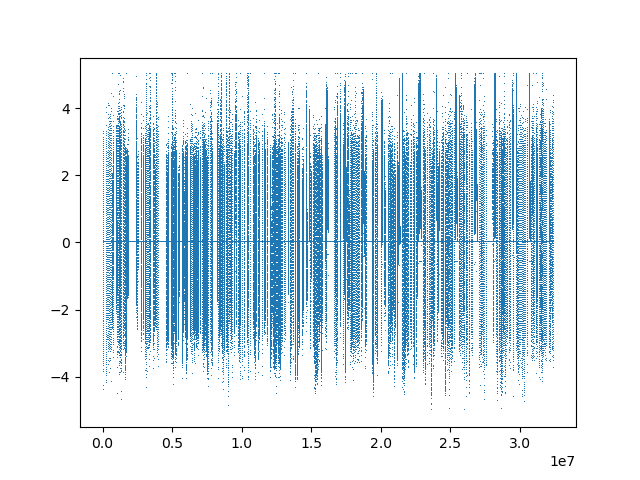

In [10]:
%matplotlib ipympl
fig = plt.figure()
plt.plot(lcfull,',')
plt.show()

In [11]:
# get the highest number of datapoints for FFT

def prev_fast_FFT_len(n):
    ntry = abs(n)
    nfft = sp.fft.next_fast_len(ntry)
    while nfft > n and ntry > 1:
        ntry = int(ntry * 0.99) - 1
        nfft = sp.fft.next_fast_len(ntry)
    return nfft

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import savgol_filter
from lmfit.models import LorentzianModel, ConstantModel, PowerLawModel
from astropy.io import fits
from pathlib import Path

def fit_frequencies(datasegment, frange=[.1, 5]):
    # Access the specific lightcurve segment
    #datasegment = lcsegments[n]
    n = prev_fast_FFT_len(len(datasegment))

    # Trim to the last n values
    datasegment = datasegment[-n:]
    duration = datasegment['time'].ptp()
    filtered_data = datasegment['norm']
    ntimes = len(filtered_data)

    # Do the Fourier transform, and get the corresponding frequencies and powers
    fnorm = sp.fft.rfft(filtered_data, norm='forward')
    freqs = abs(sp.fft.rfftfreq(ntimes, timebin))
    fpower = np.abs(fnorm)**2
    w = (freqs > frange[0])&(freqs < frange[1])
    freqs = freqs[w]
    fpower = fpower[w]
    

    qpo_index = np.argmax(fpower)
    qpo_frequency = freqs[qpo_index]
    qpo_intensity = fpower[qpo_index]

    # Prepare data for fitting
    x = freqs
    y = fpower
        
    w = savgol_filter(y, 51, 2)

    # Define multiple Lorentzian models
    mod1 = PowerLawModel(prefix='p1_')
    mod2 = LorentzianModel(prefix='l2_')
    mod3 = ConstantModel(prefix='c1_')
    mod = mod1 + mod2 + mod3

    # Initial guesses
    pars = mod1.guess(w, x=x)
    pars.update(mod2.make_params())
    pars.update(mod3.make_params())

    # Fit the model
    out = mod.fit(w, pars, x=x)
    return out, freqs, fpower
    

In [10]:
def plot_fit(fitout, freqs, fpower, n):
    # Plot the data and the fit for this segment
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, fpower, label='Data')
    plt.plot(freqs, out.best_fit, label='Fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(f'Segment {n}')
    plt.legend()
    plt.show()

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 284
    # data points      = 4390
    # variables        = 6
    chi-square         = 1.5539e-06
    reduced chi-square = 3.5444e-10
    Akaike info crit   = -95522.5534
    Bayesian info crit = -95484.2309
    R-squared          = 0.24309983
[[Variables]]
    p1_amplitude:  3.4747e-04 +/- 3.3663e-04 (96.88%) (init = 6.788031e-05)
    p1_exponent:  -0.04542335 +/- 0.04398544 (96.83%) (init = -0.1491422)
    l2_amplitude: -1.3101e-05 +/- 1.5152e-06 (11.56%) (init = 1)
    l2_center:     0.59434206 +/- 0.00889481 (1.50%) (init = 0)
    l2_sigma:      0.13670561 +/- 0.01673071 (12.24%) (init = 1)
    l2_fwhm:       0.27341123 +/- 0.03346143 (12.24%) == '2.0000000*l2_sigma'
    l2_height:    -3.0506e-05 +/- 1.9836e-06 (6.50%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:         -2.7057e-0

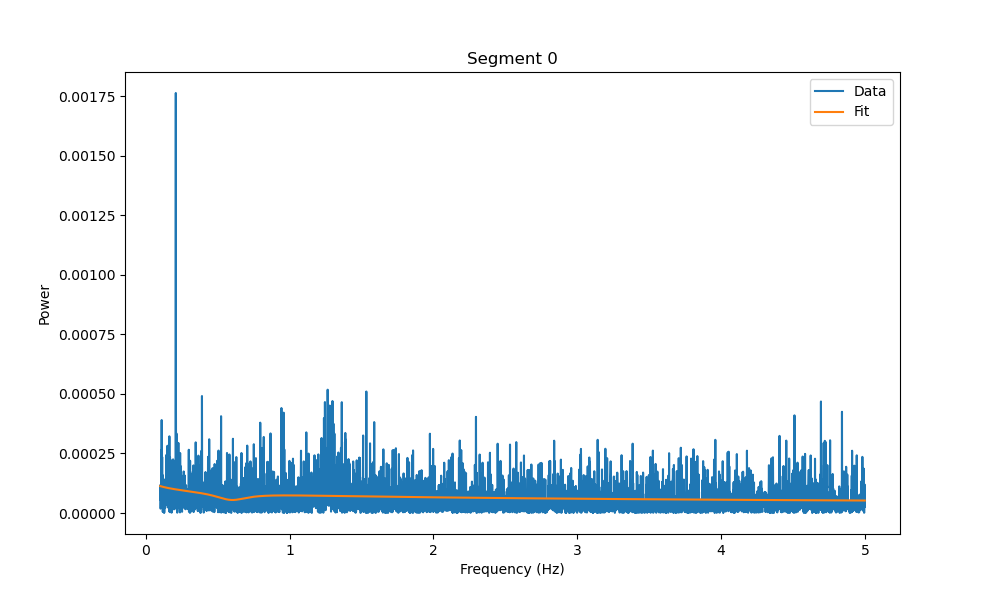

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4547
    # data points      = 4939
    # variables        = 6
    chi-square         = 2.4768e-06
    reduced chi-square = 5.0210e-10
    Akaike info crit   = -105749.000
    Bayesian info crit = -105709.971
    R-squared          = 0.92933883
[[Variables]]
    p1_amplitude: -7.67298404 +/- 21833.6202 (284551.88%) (init = 7.885425e-05)
    p1_exponent:   4.6989e-06 +/- 0.01345977 (286443.16%) (init = -0.6410242)
    l2_amplitude:  9.0921e-05 +/- 6.4504e-07 (0.71%) (init = 1)
    l2_center:     1.09814793 +/- 3.1799e-04 (0.03%) (init = 0)
    l2_sigma:      0.05110591 +/- 4.8156e-04 (0.94%) (init = 1)
    l2_fwhm:       0.10221183 +/- 9.6312e-04 (0.94%) == '2.0000000*l2_sigma'
    l2_height:     5.6630e-04 +/- 3.5231e-06 (0.62%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:          7.6

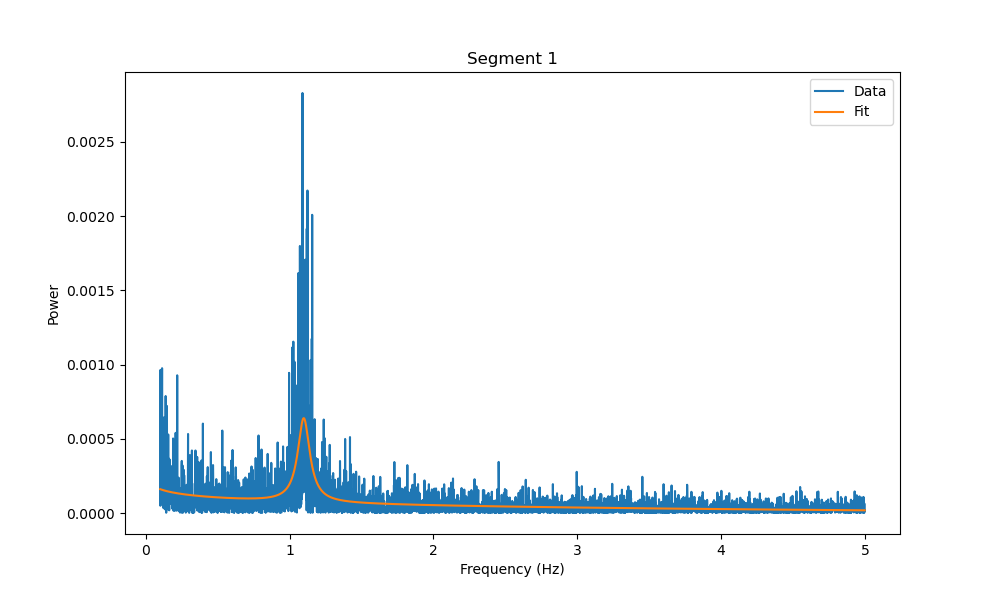

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4685
    # data points      = 4967
    # variables        = 6
    chi-square         = 3.4440e-06
    reduced chi-square = 6.9422e-10
    Akaike info crit   = -104739.221
    Bayesian info crit = -104700.157
    R-squared          = 0.94418752
[[Variables]]
    p1_amplitude: -9.91096866 +/- 21033.1403 (212220.83%) (init = 8.865832e-05)
    p1_exponent:   4.8712e-06 +/- 0.01040928 (213689.05%) (init = -0.8086589)
    l2_amplitude:  1.2928e-04 +/- 7.9650e-07 (0.62%) (init = 1)
    l2_center:     1.18189912 +/- 3.1034e-04 (0.03%) (init = 0)
    l2_sigma:      0.05718160 +/- 4.6822e-04 (0.82%) (init = 1)
    l2_fwhm:       0.11436319 +/- 9.3645e-04 (0.82%) == '2.0000000*l2_sigma'
    l2_height:     7.1968e-04 +/- 3.9053e-06 (0.54%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:          9.9

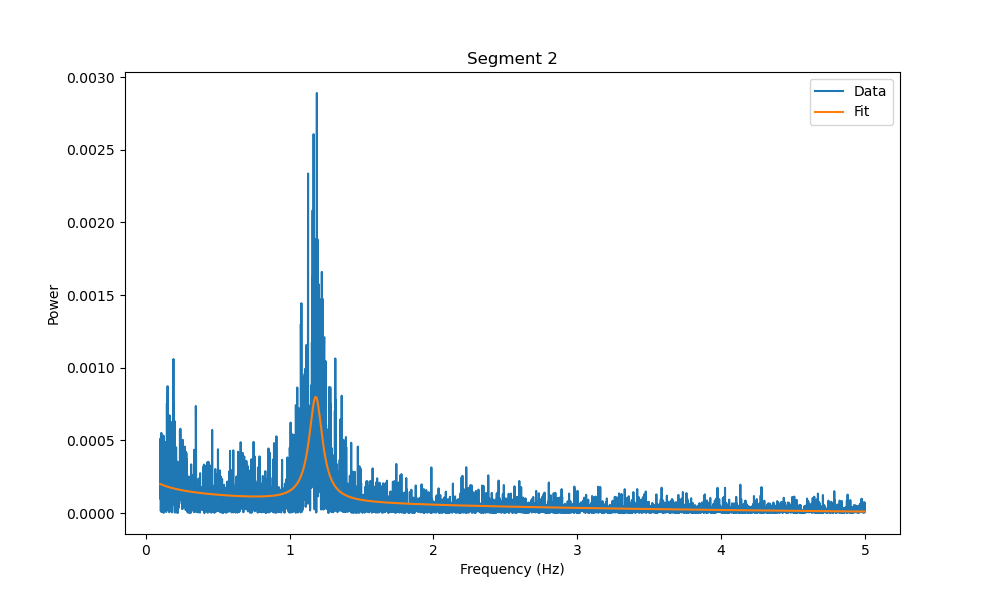

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4518
    # data points      = 1449
    # variables        = 6
    chi-square         = 5.5648e-06
    reduced chi-square = 3.8564e-09
    Akaike info crit   = -28066.2522
    Bayesian info crit = -28034.5805
    R-squared          = 0.33912400
[[Variables]]
    p1_amplitude: -4.29441406 +/- 6718.53132 (156448.15%) (init = 0.0001767526)
    p1_exponent:   6.1505e-05 +/- 0.09635139 (156656.05%) (init = -0.2575697)
    l2_amplitude: -6.18672630 +/- 210186.026 (3397370.68%) (init = 1)
    l2_center:    -2.38540291 +/- 0.60037058 (25.17%) (init = 0)
    l2_sigma:      0.00250032 +/- 85.1221206 (3404448.29%) (init = 1)
    l2_fwhm:       0.00500064 +/- 170.244241 (3404448.28%) == '2.0000000*l2_sigma'
    l2_height:    -787.617500 +/- 53572316.5 (6801818.96%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma

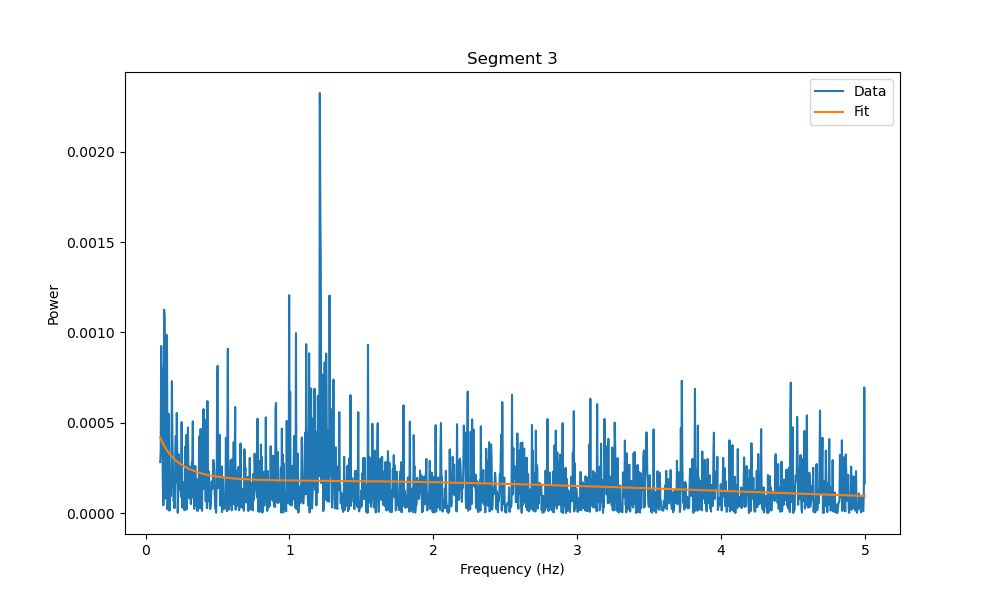

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3318
    # data points      = 7025
    # variables        = 6
    chi-square         = 6.2688e-07
    reduced chi-square = 8.9312e-11
    Akaike info crit   = -162544.695
    Bayesian info crit = -162503.551
    R-squared          = 0.82214438
[[Variables]]
    p1_amplitude: -1.51256852 +/- 5058.75264 (334447.83%) (init = 4.154328e-05)
    p1_exponent:   6.7436e-06 +/- 0.02275595 (337444.24%) (init = -0.3161854)
    l2_amplitude:  2.2891e-05 +/- 2.4387e-07 (1.07%) (init = 1)
    l2_center:     1.14548300 +/- 4.9626e-04 (0.04%) (init = 0)
    l2_sigma:      0.05481953 +/- 7.6084e-04 (1.39%) (init = 1)
    l2_fwhm:       0.10963906 +/- 0.00152167 (1.39%) == '2.0000000*l2_sigma'
    l2_height:     1.3292e-04 +/- 1.2037e-06 (0.91%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:          1.5

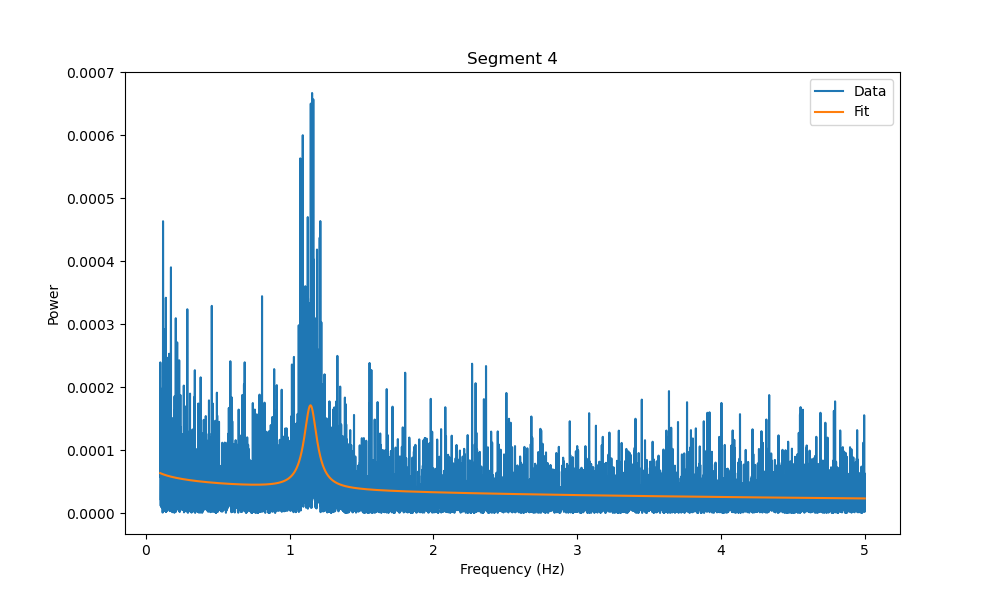

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 139
    # data points      = 3513
    # variables        = 6
    chi-square         = 4.2342e-07
    reduced chi-square = 1.2074e-10
    Akaike info crit   = -80221.8437
    Bayesian info crit = -80184.8584
    R-squared          = 0.76691291
[[Variables]]
    p1_amplitude:  7.9789e-06 +/- 5.2039e-07 (6.52%) (init = 4.497707e-05)
    p1_exponent:  -1.14882449 +/- 0.03374668 (2.94%) (init = -0.3513224)
    l2_amplitude:  2.6491e-05 +/- 5.1315e-07 (1.94%) (init = 1)
    l2_center:     1.13406592 +/- 0.00138471 (0.12%) (init = 0)
    l2_sigma:      0.08589700 +/- 0.00214911 (2.50%) (init = 1)
    l2_fwhm:       0.17179400 +/- 0.00429822 (2.50%) == '2.0000000*l2_sigma'
    l2_height:     9.8167e-05 +/- 1.5811e-06 (1.61%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:          2.7330e-05 +/-

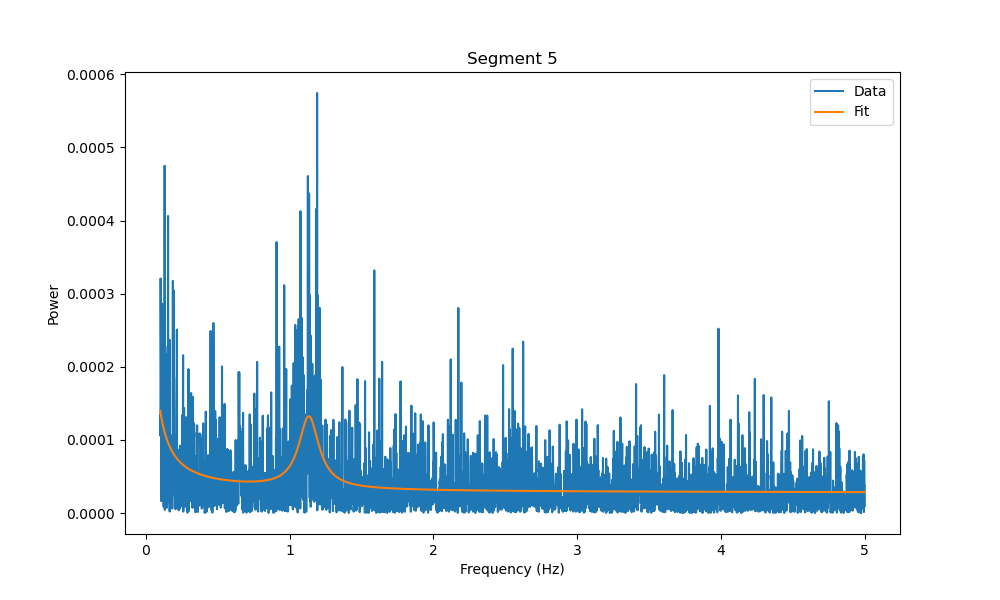

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1934
    # data points      = 2634
    # variables        = 6
    chi-square         = 2.0455e-06
    reduced chi-square = 7.7833e-10
    Akaike info crit   = -55239.1691
    Bayesian info crit = -55203.9116
    R-squared          = 0.49557443
[[Variables]]
    p1_amplitude: -0.62272393 +/- 2590.68084 (416023.97%) (init = 0.0001236854)
    p1_exponent:   2.2825e-05 +/- 0.09607786 (420936.42%) (init = -0.1303933)
    l2_amplitude:  2.7053e-05 +/- 9.8576e-07 (3.64%) (init = 1)
    l2_center:     1.25401965 +/- 0.00129995 (0.10%) (init = 0)
    l2_sigma:      0.04081016 +/- 0.00196698 (4.82%) (init = 1)
    l2_fwhm:       0.08162032 +/- 0.00393396 (4.82%) == '2.0000000*l2_sigma'
    l2_height:     2.1101e-04 +/- 6.7223e-06 (3.19%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:          0.6

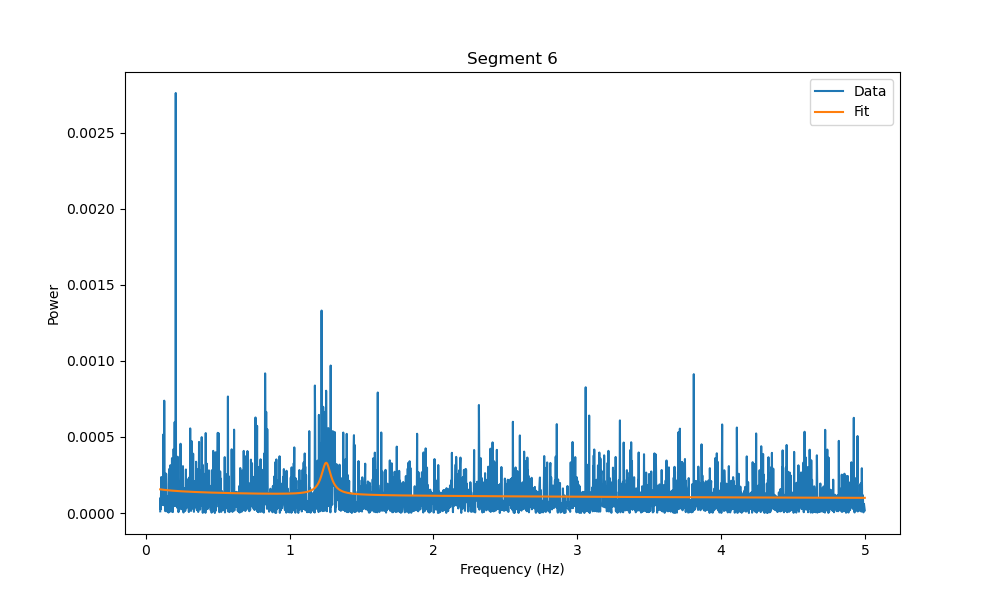

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 1175
    # variables        = 6
    chi-square         = 9.2788e-06
    reduced chi-square = 7.9374e-09
    Akaike info crit   = -21909.7402
    Bayesian info crit = -21879.3261
    R-squared          = 0.45187621
##  Warning: uncertainties could not be estimated:
[[Variables]]
    p1_amplitude: -0.08729697 (init = 0.0001615651)
    p1_exponent:   0.00199540 (init = -0.4883046)
    l2_amplitude: -3.3503e-04 (init = 1)
    l2_center:     0.42314110 (init = 0)
    l2_sigma:      0.34551129 (init = 1)
    l2_fwhm:       0.69102259 == '2.0000000*l2_sigma'
    l2_height:    -3.0866e-04 == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:          0.08760845 (init = 0)


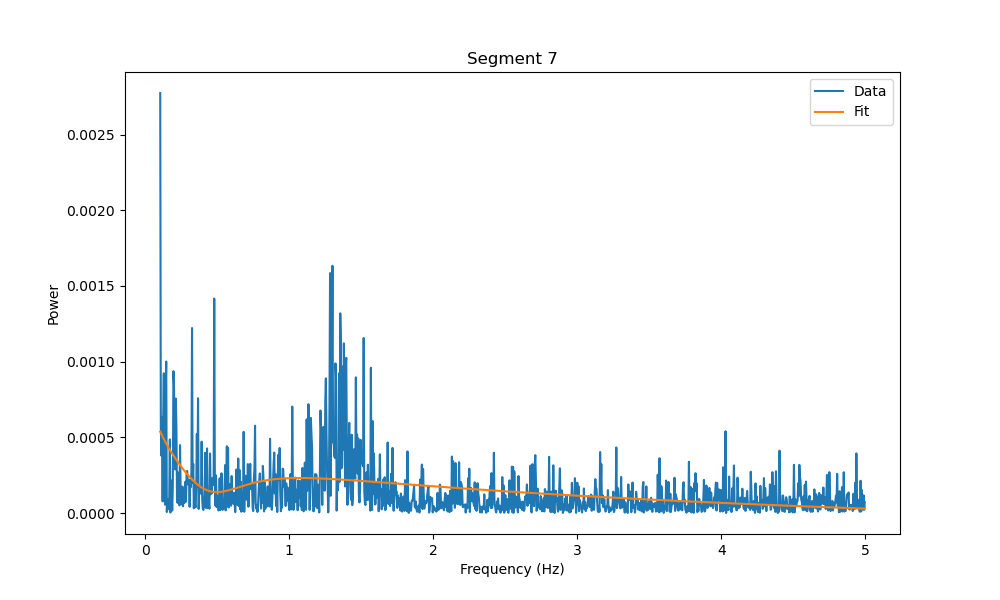

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 610
    # data points      = 2922
    # variables        = 6
    chi-square         = 4.3429e-05
    reduced chi-square = 1.4893e-08
    Akaike info crit   = -52655.2936
    Bayesian info crit = -52619.4135
    R-squared          = 0.29458102
[[Variables]]
    p1_amplitude: -7.1738e-04 +/- 2.7130e-04 (37.82%) (init = 0.0001197289)
    p1_exponent:   0.20026418 +/- 0.06170209 (30.81%) (init = -0.7085943)
    l2_amplitude: -2.4708e-04 +/- 4.9969e-05 (20.22%) (init = 1)
    l2_center:     0.47987773 +/- 0.02240042 (4.67%) (init = 0)
    l2_sigma:      0.30883065 +/- 0.04358225 (14.11%) (init = 1)
    l2_fwhm:       0.61766129 +/- 0.08716450 (14.11%) == '2.0000000*l2_sigma'
    l2_height:    -2.5466e-04 +/- 2.1453e-05 (8.42%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:          9.8052e-0

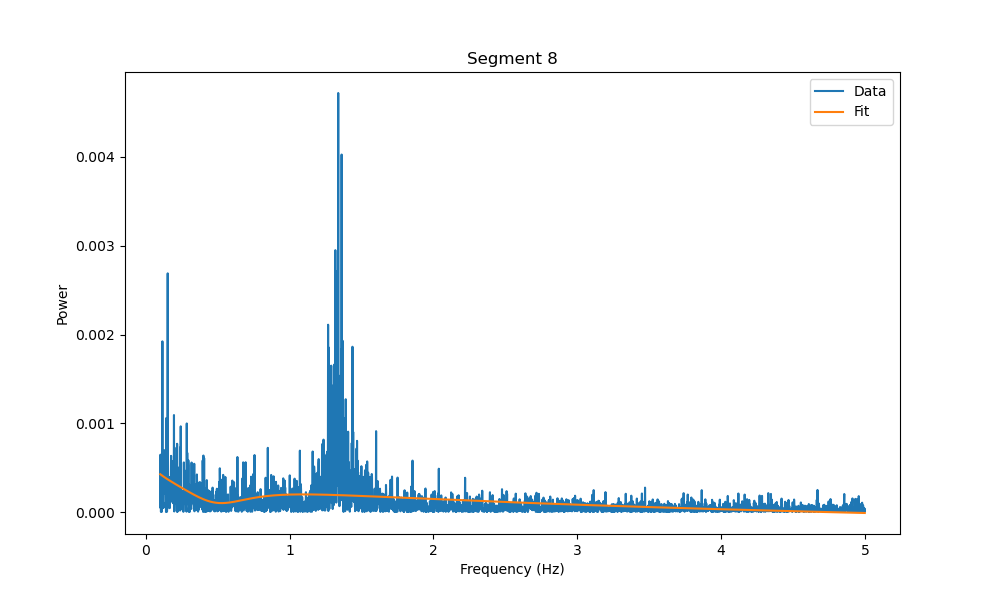

[[Model]]
    ((Model(powerlaw, prefix='p1_') + Model(lorentzian, prefix='l2_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4462
    # data points      = 5268
    # variables        = 6
    chi-square         = 1.5977e-05
    reduced chi-square = 3.0364e-09
    Akaike info crit   = -103313.171
    Bayesian info crit = -103273.754
    R-squared          = 0.33152013
[[Variables]]
    p1_amplitude:  0.00265314 +/- 0.02348648 (885.23%) (init = 6.918881e-05)
    p1_exponent:   1.08100236 +/- 0.75098667 (69.47%) (init = -0.668839)
    l2_amplitude:  3.62872745 +/- 49.8322442 (1373.27%) (init = 1)
    l2_center:    -4.85088785 +/- 31.4921143 (649.20%) (init = 0)
    l2_sigma:      15.2885378 +/- 50.5924774 (330.92%) (init = 1)
    l2_fwhm:       30.5770756 +/- 101.184955 (330.92%) == '2.0000000*l2_sigma'
    l2_height:     0.07555071 +/- 0.78751004 (1042.36%) == '0.3183099*l2_amplitude/max(1e-15, l2_sigma)'
    c1_c:         

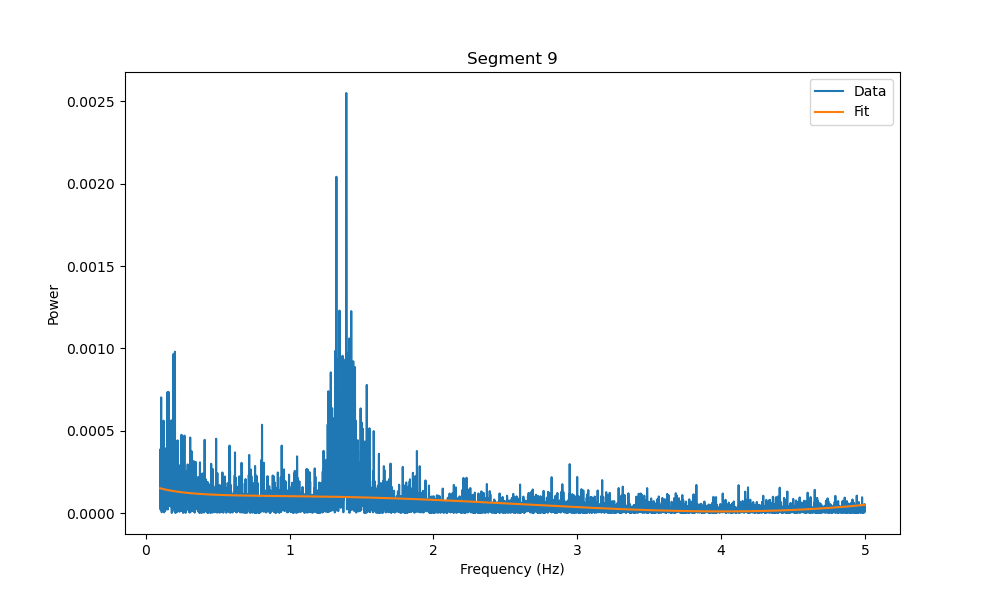

In [11]:


# Load the Swift flux data
swiftflux = "SWIFTJ1727.8-1613.lc.fits"
pathname = Path("~/Downloads").expanduser()
swiftfilename = list(pathname.rglob(swiftflux))

if not swiftfilename:
    raise FileNotFoundError(f"File {swiftflux} not found in {pathname}")

sdata, sheader = fits.getdata(swiftfilename[0], header=True)
swift_times = sdata['TIME']
swift_flux = sdata['RATE']

# Initialize lists to store statistics and time
times = []
center_frequencies = []
widths = []
intensities = []
cerr = []
werr = []
#ierr = []

for i, datasegment in enumerate(lcsegments[100:110]):
    out, freqs, fpower = fit_frequencies(datasegment)
    print(out.fit_report(min_correl=1))
    plot_fit(out, freqs, fpower, i)
    if out.params['l2_center'] < .2:
        continue
        

    # Extract statistics
    # center_frequencies.append(out.params['l1_center'].value)
    # widths.append(out.params['l1_fwhm'].value)
    # intensities.append(qpo_intensity)
    # cerr.append(out.params['l1_center'].stderr)
    # werr.append(out.params['l1_fwhm'].stderr)

    
    #ierr.append(out.params['l1_sigma'].stderr)

    # Plot the data and the fit for this segment
    #plt.figure(figsize=(10, 6))
    # plt.plot(x, y, label='Data')
    #plt.plot(x, out.best_fit, label='Fit')
    #plt.xlabel('Frequency (Hz)')
    #plt.ylabel('Power')
    # plt.title(f'Segment {n}')
    # plt.legend()
    # plt.show()

# Replace None values in error arrays with zeros
# cerr = [0 if v is None else v for v in cerr]
# werr = [0 if v is None else v for v in werr]
# #ierr = [0 if v is None else v for v in ierr]

# # Convert lists to numpy arrays
# center_frequencies = np.array(center_frequencies)
# widths = np.array(widths)
# intensities = np.array(intensities)
# cerr = np.array(cerr)
# werr = np.array(werr)
# #ierr = np.array(ierr)

# # sorted_indices = np.argsort(swift_times)
# # center_frequencies = center_frequencies[sorted_indices]
# # widths = widths[sorted_indices]
# # intensities = intensities[sorted_indices]
    

# # Ensure all arrays have the same length
# min_len = min(len(swift_times), len(center_frequencies), len(widths), len(intensities))

# swift_times = swift_times[:min_len]
# center_frequencies = center_frequencies[:min_len]
# widths = widths[:min_len]
# intensities = intensities[:min_len]
# cerr = cerr[:min_len]
# werr = werr[:min_len]
#ierr = ierr[:min_len]

In [12]:
print(len(swift_times), len(center_frequencies), len(widths), len(intensities), len(swift_flux))


207 0 0 0 207


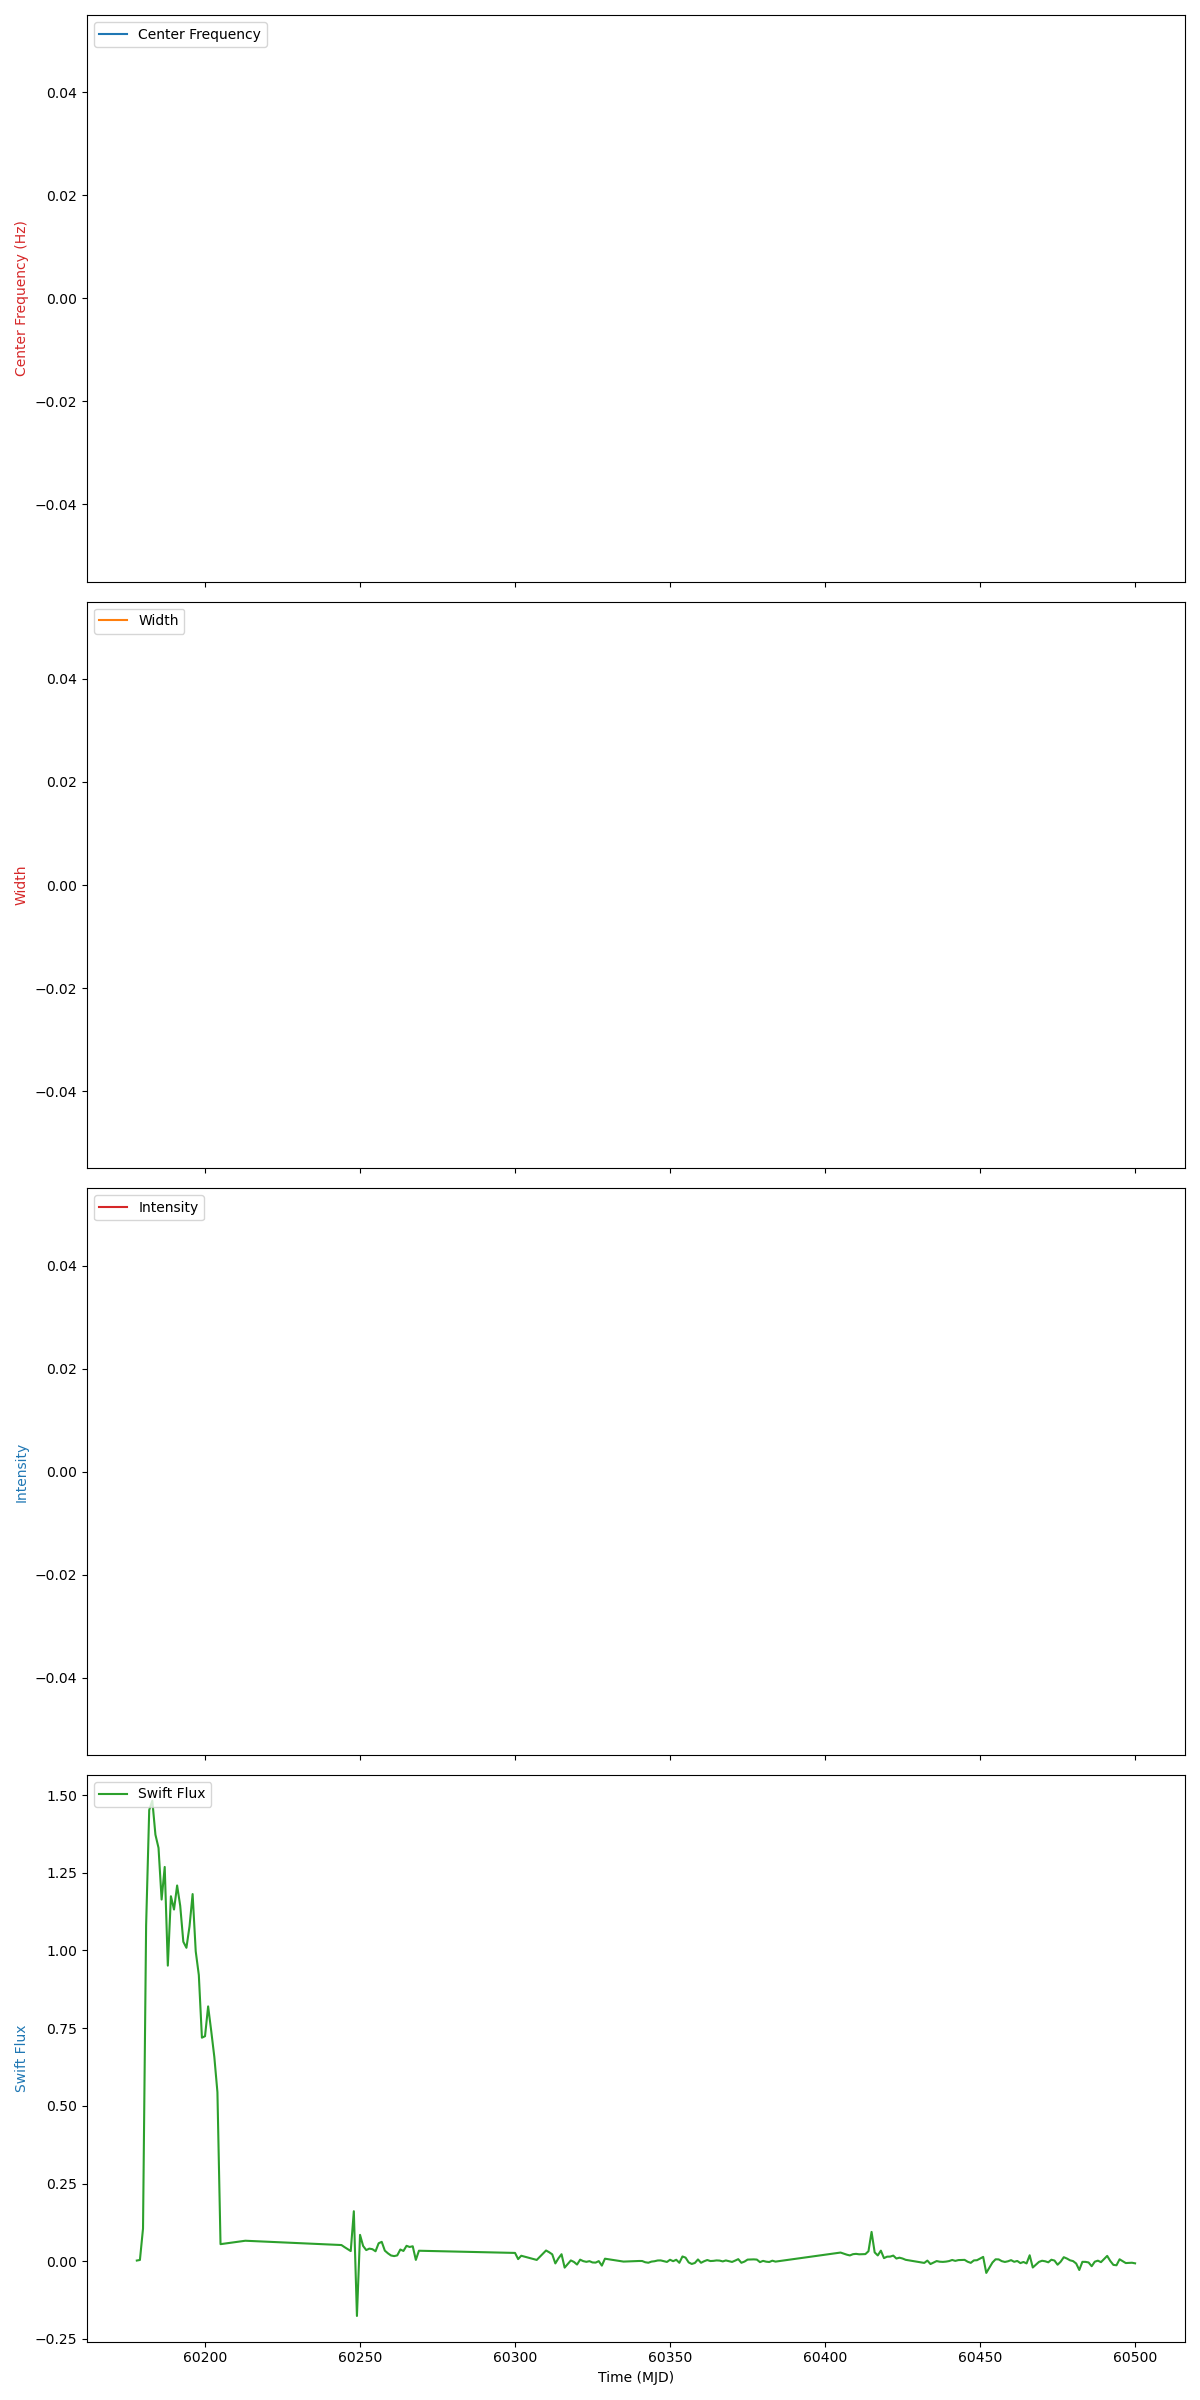

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(12, 24), sharex=True)

# Plot peak frequency
axs[0].set_ylabel('Center Frequency (Hz)', color='tab:red')
axs[0].plot(times, center_frequencies, color='tab:blue', label='Center Frequency')
#axs[0].errorbar(swift_times, center_frequencies, yerr=cerr, capsize=2, fmt="ko--", ecolor="blue")
axs[0].legend(loc='upper left')

# Plot width
axs[1].set_ylabel('Width', color='tab:red')
axs[1].plot(times, widths, color='tab:orange',  label='Width')
#axs[1].errorbar(swift_times, widths, yerr=werr, capsize=2, fmt="ko--", ecolor="orange")
axs[1].legend(loc='upper left')

# Plot amplitude
axs[2].set_ylabel('Intensity', color='tab:blue')
axs[2].plot(times, intensities, color='tab:red', label='Intensity')
axs[2].legend(loc='upper left')

# Plot Swift Flux
axs[3].set_ylabel('Swift Flux', color='tab:blue')
axs[3].plot(swift_times, swift_flux, color='tab:green', label='Swift Flux')
axs[3].legend(loc='upper left')

# Set common labels
axs[3].set_xlabel('Time (MJD)')

# Adjust layout
fig.tight_layout()
plt.show()

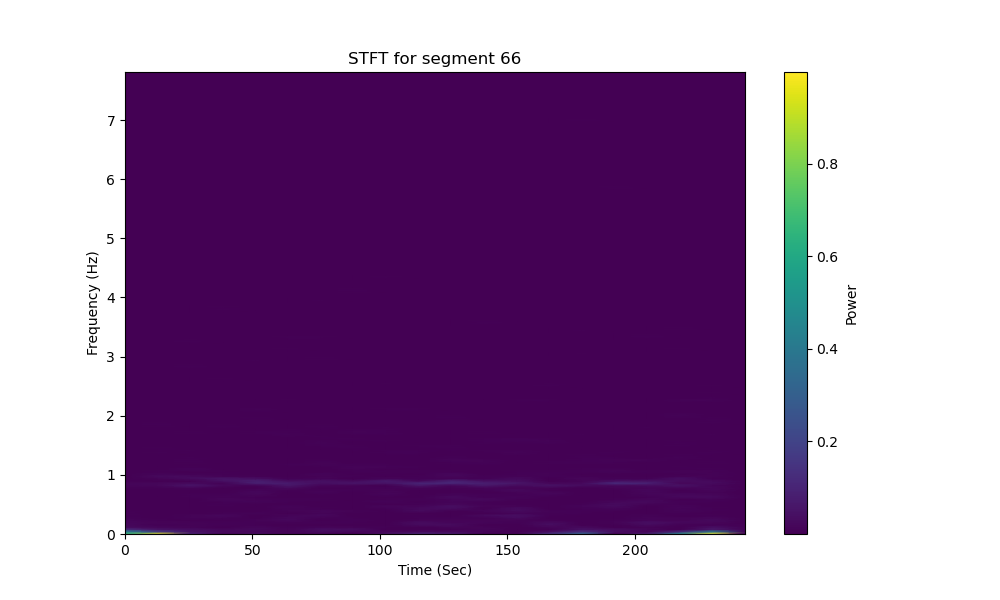

In [12]:
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt

obs = 66  # Observation index

plt.close('all')
fs = 1 / timebin  # Sampling frequency

def plot_QPO_segment(obs):
    # Access the specific lightcurve segment
    datasegment = lcsegments[obs]
    filtered_data = datasegment['norm']
    
    # Perform STFT
    f, t, Zxx = stft(filtered_data, fs=fs, nperseg=400, scaling='spectrum')
    
    # Plot STFT results with power
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, np.abs(Zxx)**2, shading='gouraud')  # Use power instead of magnitude
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (Sec)')
    plt.title(f'STFT for segment {obs}')
    plt.colorbar(label='Power')
    plt.show()

# Call the function to plot the specific observation
plot_QPO_segment(obs)


In [13]:
# Copyright 2018, Tom Eulenfeld, MIT license
"""
Calculate 2D, 1D, 0D bicoherence, bispectrum, polycoherence and polyspectrum
"""

from math import pi
import numpy as np
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
import matplotlib.pyplot as plt


def __get_norm(norm):
    if norm == 0 or norm is None:
        return None, None
    else:
        try:
            norm1, norm2 = norm
        except TypeError:
            norm1 = norm2 = norm
        return norm1, norm2


def __freq_ind(freq, f0):
    try:
        return [np.argmin(np.abs(freq - f)) for f in f0]
    except TypeError:
        return np.argmin(np.abs(freq - f0))


def __product_other_freqs(spec, indices, synthetic=(), t=None):
    p1 = np.prod([amplitude * np.exp(2j * np.pi * freq * t + phase)
                  for (freq, amplitude, phase) in synthetic], axis=0)
    p2 = np.prod(spec[:, indices[len(synthetic):]], axis=1)
    return p1 * p2


def _polycoherence_0d(data, fs, *freqs, norm=2, synthetic=(), **kwargs):
    """Polycoherence between freqs and sum of freqs"""
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    ind = __freq_ind(freq, freqs)
    sum_ind = __freq_ind(freq, np.sum(freqs))
    spec = np.transpose(spec, [1, 0])
    p1 = __product_other_freqs(spec, ind, synthetic, t)
    p2 = np.conjugate(spec[:, sum_ind])
    coh = np.mean(p1 * p2, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 = np.mean(np.abs(p1) ** norm1 * np.abs(p2) ** norm2, axis=0)
        coh /= temp2
        coh **= 0.5
    return coh


def _polycoherence_1d(data, fs, *freqs, norm=2, synthetic=(), **kwargs):
    """
    Polycoherence between f1 given freqs and their sum as a function of f1
    """
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.transpose(spec, [1, 0])
    ind2 = __freq_ind(freq, freqs)
    ind1 = np.arange(len(freq) - sum(ind2))
    sumind = ind1 + sum(ind2)
    otemp = __product_other_freqs(spec, ind2, synthetic, t)[:, None]
    temp = spec[:, ind1] * otemp
    temp2 = np.mean(np.abs(temp) ** 2, axis=0)
    temp *= np.conjugate(spec[:, sumind])
    coh = np.mean(temp, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], coh


def _polycoherence_1d_sum(data, fs, f0, *ofreqs, norm=2,
                          synthetic=(), **kwargs):
    """Polycoherence with fixed frequency sum f0 as a function of f1"""
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.transpose(spec, [1, 0])
    ind3 = __freq_ind(freq, ofreqs)
    otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None]
    sumind = __freq_ind(freq, f0)
    ind1 = np.arange(np.searchsorted(freq, f0 - np.sum(ofreqs)))
    ind2 = sumind - ind1 - sum(ind3)
    temp = spec[:, ind1] * spec[:, ind2] * otemp
    if norm is not None:
        temp2 = np.mean(np.abs(temp) ** 2, axis=0)
    temp *= np.conjugate(spec[:, sumind, None])
    coh = np.mean(temp, axis=0)
    if norm is not None:
        coh = np.abs(coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], coh


def _polycoherence_2d(data, fs, *ofreqs, norm=2, flim1=None, flim2=None,
                      synthetic=(), **kwargs):
    """
    Polycoherence between freqs and their sum as a function of f1 and f2
    """
    norm1, norm2 = __get_norm(norm)
    freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
    spec = np.require(spec, 'complex64')
    spec = np.transpose(spec, [1, 0])  # transpose (f, t) -> (t, f)
    if flim1 is None:
        flim1 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    if flim2 is None:
        flim2 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
    ind1 = np.arange(*np.searchsorted(freq, flim1))
    ind2 = np.arange(*np.searchsorted(freq, flim2))
    ind3 = __freq_ind(freq, ofreqs)
    otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None, None]
    sumind = ind1[:, None] + ind2[None, :] + sum(ind3)
    temp = spec[:, ind1, None] * spec[:, None, ind2] * otemp
    if norm is not None:
        temp2 = np.mean(np.abs(temp) ** norm1, axis=0)
    temp *= np.conjugate(spec[:, sumind])
    coh = np.mean(temp, axis=0)
    del temp
    if norm is not None:
        coh = np.abs(coh, out=coh)
        coh **= 2
        temp2 *= np.mean(np.abs(spec[:, sumind]) ** norm2, axis=0)
        coh /= temp2
        coh **= 0.5
    return freq[ind1], freq[ind2], coh


def polycoherence(data, *args, dim=2, **kwargs):
    """
    Polycoherence between frequencies and their sum frequency

    Polycoherence as a function of two frequencies.

    |<prod(spec(fi)) * conj(spec(sum(fi)))>| ** n0 /
        <|prod(spec(fi))|> ** n1 * <|spec(sum(fi))|> ** n2

    i ... 1 - N: N=2 bicoherence, N>2 polycoherence
    < > ... averaging
    | | ... absolute value

    data: 1d data
    fs: sampling rate
    ofreqs: further positional arguments are fixed frequencies

    dim:
        2 - 2D polycoherence as a function of f1 and f2, ofreqs are additional
            fixed frequencies (default)
        1 - 1D polycoherence as a function of f1, at least one fixed frequency
            (ofreq) is expected
        'sum' - 1D polycoherence with fixed frequency sum. The first argument
            after fs is the frequency sum. Other fixed frequencies possible.
        0 - polycoherence for fixed frequencies
    norm:
        2 - return polycoherence, n0 = n1 = n2 = 2 (default)
        0 - return polyspectrum, <prod(spec(fi)) * conj(spec(sum(fi)))>
        tuple (n1, n2): general case with n0=2
    synthetic:
        used for synthetic signal for some frequencies,
        list of 3-item tuples (freq, amplitude, phase), freq must coincide
        with the first fixed frequencies (ofreq, except for dim='sum')
    flim1, flim2: for 2D case, frequency limits can be set
    **kwargs: are passed to scipy.signal.spectrogram. Important are the
        parameters nperseg, noverlap, nfft.
    """
    N = len(data)
    kwargs.setdefault('nperseg', N // 20)
    kwargs.setdefault('nfft', next_fast_len(N // 10))
    if dim == 0:
        f = _polycoherence_0d
    elif dim == 1:
        f = _polycoherence_1d
    elif dim == 'sum':
        f = _polycoherence_1d_sum
    elif dim == 2:
        f = _polycoherence_2d
    else:
        raise
    return f(data, *args, **kwargs)


def plot_polycoherence(freq1, freq2, bicoh, ax=None, title=None):
    """
    Plot polycoherence (i.e. return values of polycoherence with dim=2)
    """
    df1 = freq1[1] - freq1[0]
    df2 = freq2[1] - freq2[0]
    freq1 = np.append(freq1, freq1[-1] + df1) - 0.5 * df1
    freq2 = np.append(freq2, freq2[-1] + df2) - 0.5 * df2
    if ax is None:
        plt.figure()
        ax = plt.gca()
    c = ax.pcolormesh(freq2, freq1, np.abs(bicoh), shading='auto', cmap='viridis')
    ax.set_xlabel('Frequency 2 (Hz)')
    ax.set_ylabel('Frequency 1 (Hz)')
    if title is not None:
        ax.set_title(title)
    plt.colorbar(c, ax=ax)



def _plot_polycoherence_1d(freq, coh):
    plt.figure()
    plt.plot(freq, coh)
    plt.xlabel('freq (Hz)')


def _plot_signal(t, signal):
    plt.figure()
    plt.subplot(211)
    plt.plot(t, signal)
    plt.xlabel('time (s)')
    plt.subplot(212)
    ndata = len(signal)
    nfft = next_fast_len(ndata)
    freq = rfftfreq(nfft, t[1] - t[0])
    spec = rfft(signal, nfft) * 2 / ndata
    plt.plot(freq, np.abs(spec))
    plt.xlabel('freq (Hz)')
    plt.tight_layout()

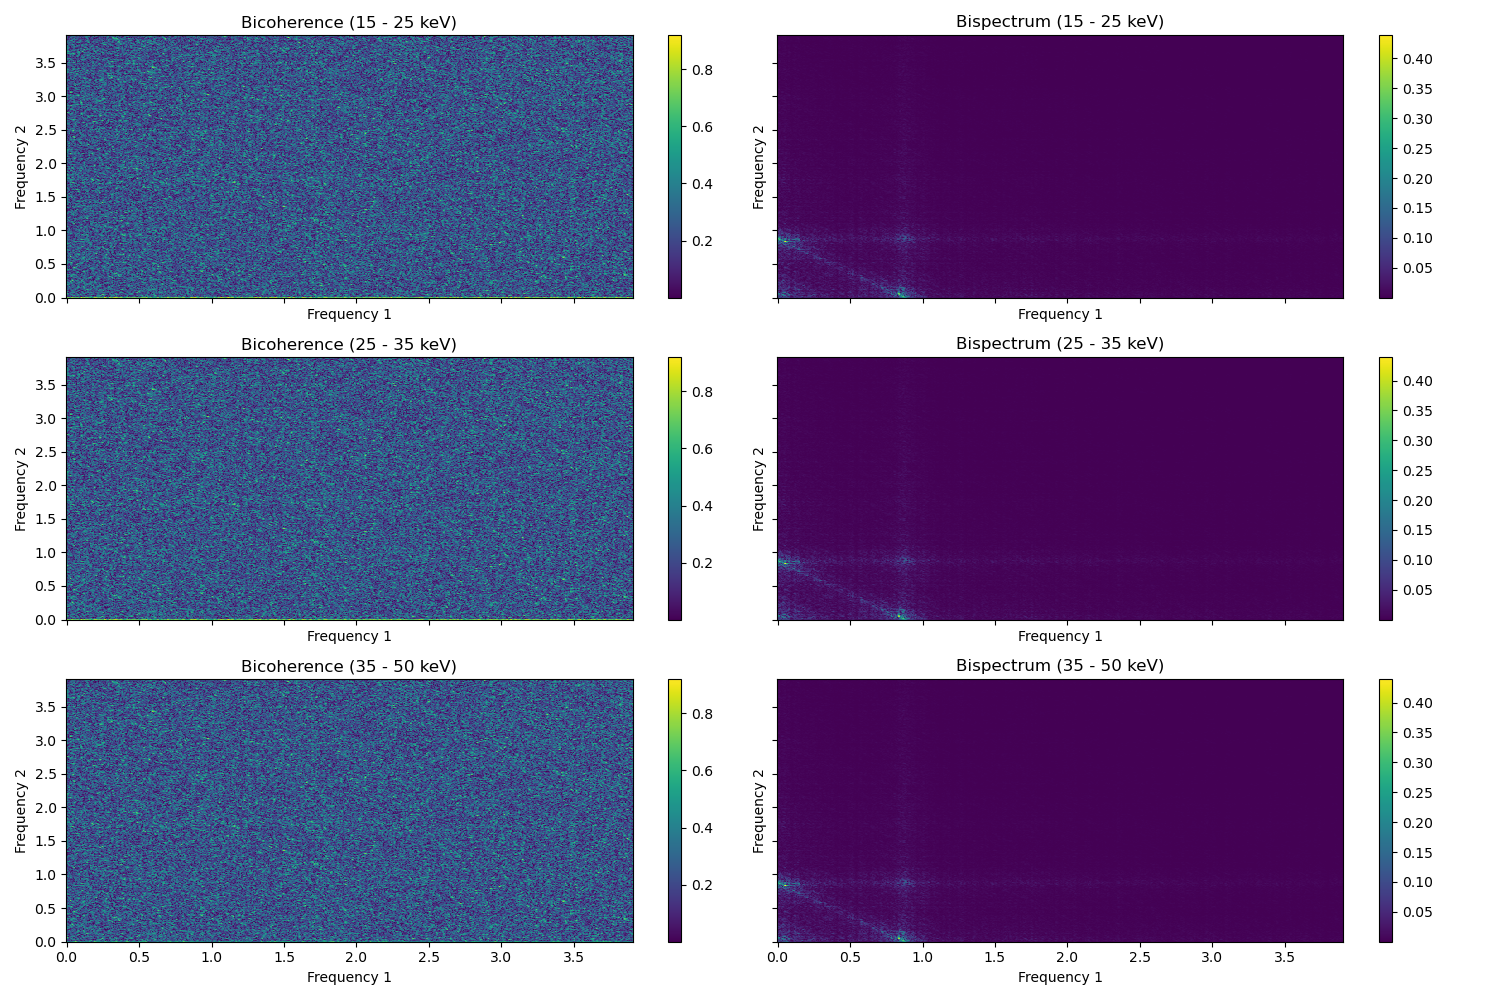

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import next_fast_len

# Assuming lcsegments and other necessary variables are defined elsewhere

obs = 63
binedges = np.array([15, 25, 35, 50])

def plot_bicoherence(filtered_data, fs, ax, energy_range, **kw):
    freq1, freq2, bicoh = polycoherence(filtered_data, fs, **kw)
    plot_polycoherence(freq1, freq2, bicoh, ax,  f"Bicoherence ({energy_range[0]} - {energy_range[1]} keV)")

def plot_bispectrum(filtered_data, fs, ax, energy_range, **kw):
    freq1, freq2, bispec = polycoherence(filtered_data, fs, norm=None, **kw)
    plot_polycoherence(freq1, freq2, bispec, ax,  f"Bispectrum ({energy_range[0]} - {energy_range[1]} keV)")

# Create the figure with subplots for each energy bin
n_plots = 2  # Number of different plots (e.g., bicoherence, bispectrum)
fig, axes = plt.subplots(nrows=len(binedges) - 1, ncols=n_plots, figsize=(15, 10), sharex=True, sharey=True)

# Plot bicoherence and bispectrum for each energy band
for i in range(len(binedges) - 1):
    filtered_data = lcsegments[obs]['norm']  # Adjust this based on your actual data structure
    kw = dict(nperseg=10001 // 10, noverlap=10001 // 20, nfft=next_fast_len(10001 // 2))
    energy_range = (binedges[i], binedges[i + 1])
    
    # Plot bicoherence
    plot_bicoherence(filtered_data, fs, axes[i, 0], energy_range, **kw)
    
    # Plot bispectrum
    plot_bispectrum(filtered_data, fs, axes[i, 1], energy_range, **kw)

    # Set subplot labels
    axes[i, 0].set_ylabel('Frequency 2')
    axes[i, 0].set_xlabel('Frequency 1')
    axes[i, 1].set_ylabel('Frequency 2')
    axes[i, 1].set_xlabel('Frequency 1')
    
# Adjust overall plot layout
plt.tight_layout()
plt.show()

In [7]:
import corner
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import lmfit
import pandas as pd

# Debug function to print parameter values
def check_parameters(params):
    for param_name, param in params.items():
        print(f'{param_name}: {param.value}, err: {param.stderr}')

# Function to filter l1 parameters from the MCMC results
def filter_l1_params(flatchain, var_names):
    # Identify `l1` parameters
    l1_params = [name for name in var_names if name.startswith('l1_')]
    l1_indices = [var_names.index(name) for name in l1_params]

    # Convert flatchain to NumPy array if it's a DataFrame
    if isinstance(flatchain, pd.DataFrame):
        flatchain = flatchain.to_numpy()
        
    # Filter the flatchain to include only `l1` parameters
    l1_flatchain = flatchain[:, l1_indices]
    return l1_flatchain, l1_params


# Function to run MCMC
def run_emcee():
    # Adjust MCMC settings
    emcee_kws = dict(steps=47550, burn=10000, thin=5, is_weighted=False, progress=True)
    
    # Copy parameters and adjust bounds
    emcee_params = out.params.copy()
    
    # Fit the model using MCMC
    try:
        result_emcee = mod.fit(data=y, x=x, params=emcee_params, method='emcee', nan_policy='omit', fit_kws=emcee_kws)
        
        # Convert lmfit result to if title is not None:
        ax.set_title(title)
    plt.colorbar(c, ax=ax)InferenceData for arviz
        posterior_samples = result_emcee.flatchain
        idata = az.from_dict(posterior_samples.to_dict('list'))
        
        return result_emcee, idata
    
    except Exception as e:
        print(f"Error during MCMC run: {e}")
        return None, None

# Run MCMC and handle results
if __name__ == "__main__":
    result_emcee, idata = run_emcee()

    if result_emcee and idata:
        # Filter for l1 parameters
        l1_flatchain, l1_params = filter_l1_params(result_emcee.flatchain, result_emcee.var_names)
        
        # Convert filtered samples to InferenceData for arviz
        l1_idata = az.from_dict({name: l1_flatchain[:, i] for i, name in enumerate(l1_params)})

        # Plot trace for l1 parameters using arviz
        az.plot_trace(l1_idata)
        plt.show()

        # Debug output for l1 parameter values
        print("Filtered l1 parameters:")
        for param_name in l1_params:
            print(f'{param_name}: {result_emcee.params[param_name].value}, err: {result_emcee.params[param_name].stderr}')

        # Plot corner plot for l1 parameters
        emcee_corner = corner.corner(l1_flatchain, labels=l1_params)
        plt.show()
    else:
        print("MCMC run failed.")

SyntaxError: expected 'except' or 'finally' block (3254717535.py, line 42)